In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
from scipy.optimize import curve_fit
from scipy import special
import glob
import os
plt.style.use(['science','notebook','grid'])
import matplotlib.ticker as ticker

- $$ M = I^{0} T^{1} I^{1} $$
<br>
- $$ n_{0} = n_{air} $$
- $$ n_{1} = n_{Ti02} $$
- $$ n_{2} = n_{B270} $$

# Pas de couche

In [2]:
#Data frame du spectre de lumière blanche
len0 = pd.read_csv('1re séance/lentille_0.txt',delimiter='\t',skiprows=17,names=['x','y'],decimal=',')
len0['x'] = len0['x'].apply(lambda x: x.replace(',','.'))
len0.drop(3648,inplace=True)
len0['y'] = len0['y'] / 350 #temps d'intégration
len0['x'] = len0['x'].apply(lambda x: float(x))

Text(0.5, 1.0, 'Spectre sans couche')

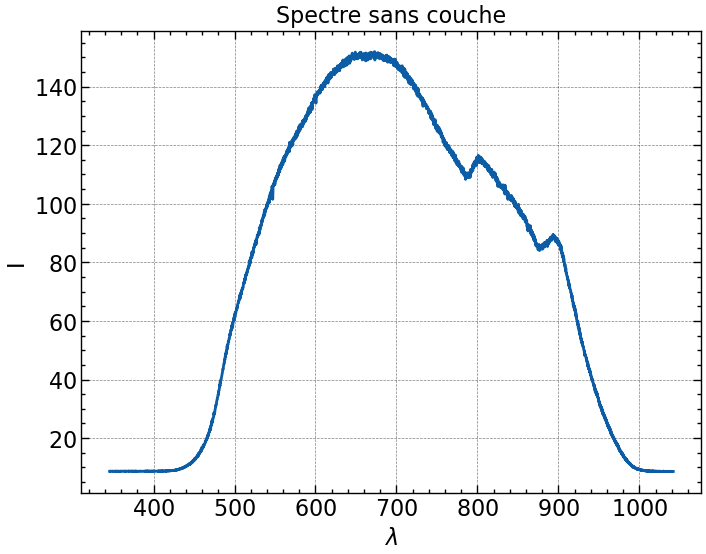

In [3]:
plt.plot(len0['x'],len0['y'])
plt.xlabel('$\lambda$')
plt.ylabel('I')
plt.title('Spectre sans couche')

# Couche 1

In [4]:
#Dataframe pour spectre avec Échantillon 1 qu'on nomme len1
len1 = pd.read_csv('1re séance/lentille_1.txt',delimiter='\t',skiprows=17,names=['x','y'],decimal=',')
len1['x'] = len1['x'].apply(lambda x: x.replace(',','.'))
len1.drop(3648,inplace=True)
len1['y'] = len1['y'] / 350 #temps d'intégration
len1['x'] = len1['x'].apply(lambda x: float(x))

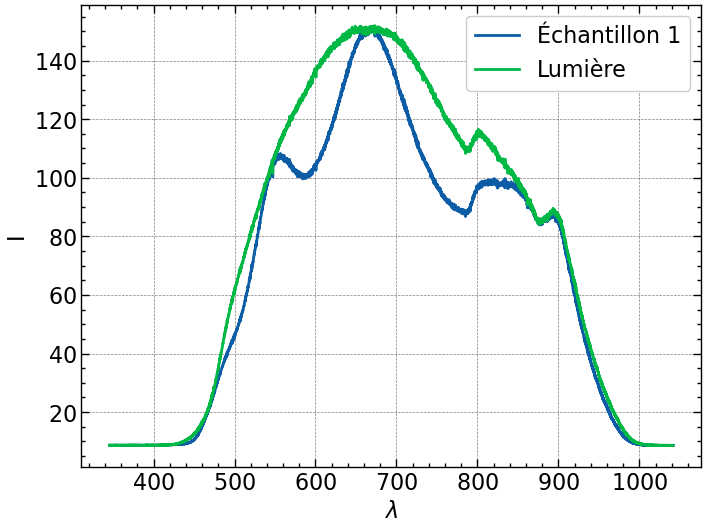

In [5]:
plt.plot(len1['x'],len1['y'],label='Échantillon 1')
plt.plot(len0['x'],len0['y'],label='Lumière')
plt.xlabel('$\lambda$')
plt.ylabel('I')
#plt.title('Spectre couche 1')
plt.legend()
plt.savefig('Couche1-Lum')

# Transmittance couche 1

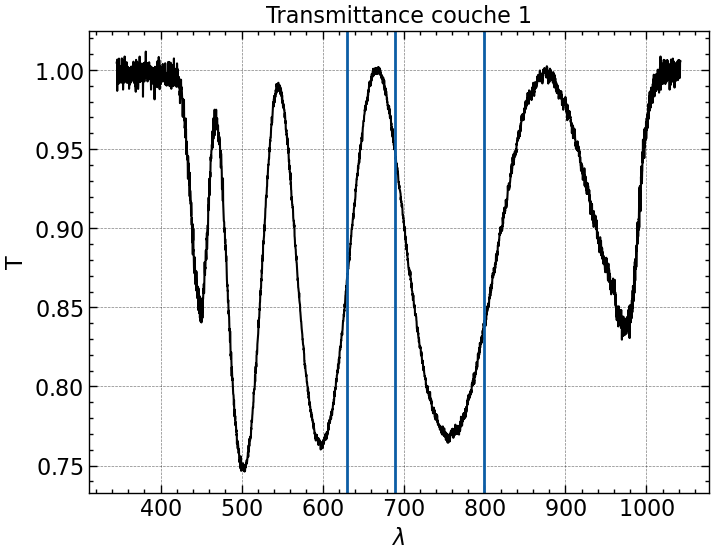

In [9]:
#Dataframe du spectre de transmittance
len1_T = pd.DataFrame(list(zip(len1['x'],len1['y']/len0['y'])),columns=['x','y'])
plt.plot(len1_T['x'],len1_T['y'],linewidth=1.5,color='black')
plt.xlabel('$\lambda$')
plt.ylabel('T')
plt.title('Transmittance couche 1')

#On définit la zone d'intérêt
plt.axvline(630,linewidth = 2)
plt.axvline(690,linewidth = 2)
plt.axvline(800,linewidth = 2)

669.25


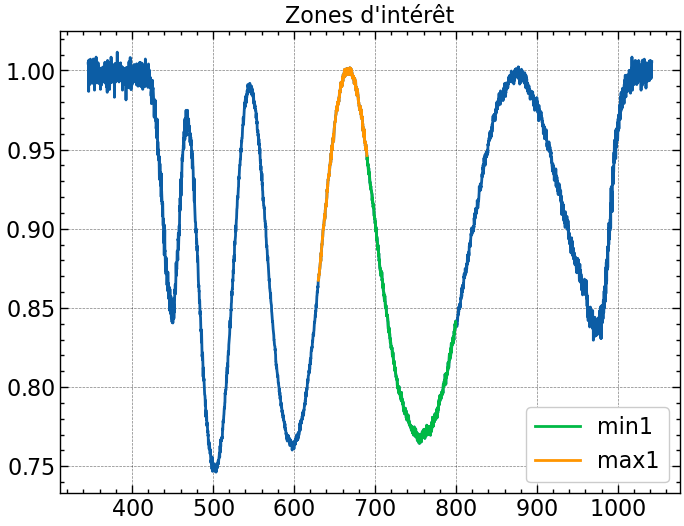

In [17]:
#Définir les dataframes des zones qui nous intérêssent pour trouver la position de leur min et max
df_min = len1_T[(len1_T['x']>690) & (len1_T['x']<800)]
df_max = len1_T[(len1_T['x']>630) & (len1_T['x']<690)]

#min
min1 = float(df_min[df_min['y'] == min(df_min['y'])]['x'])

#max
max1 = float(df_max[df_max['y'] == max(df_max['y'])]['x'])

#Graphiquement
plt.plot(len1_T['x'],len1_T['y'])
plt.plot(df_min['x'],df_min['y'],label='min1')
plt.plot(df_max['x'],df_max['y'],label='max1')
plt.title("Zones d'intérêt")
plt.legend()


### Approche matricielle

- On utilise l'équation de Transmittance sur laquelle on loupe toutes les valeurs de lambda, içi len1['x'].
- Pour pouvoir voir plusieurs spèctres, il suffit de mettre une liste dans la loop for pour le d

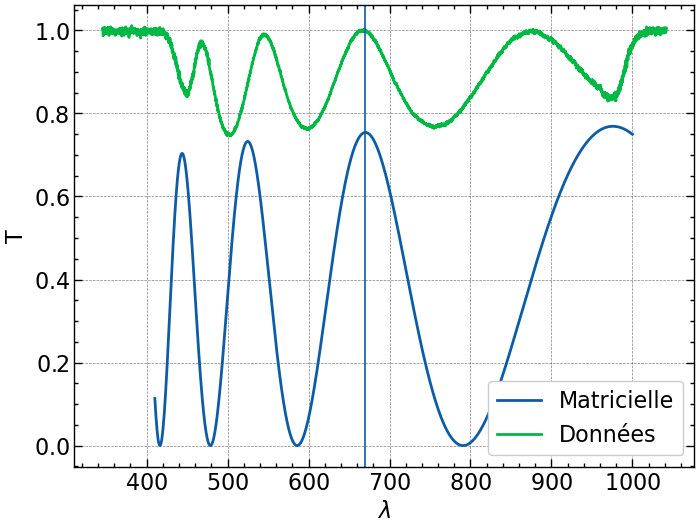

In [22]:

for d in [196]:
    Transmittance = []

    for lam in list(len1['x']) : #lambda en nm    
       
        #Nos coefficient de réfraction

        n0 = 1 - (0.057892105/(238.0185 - (lam*10**-3)**-2)) + 0.00167917/(57.362 - (lam*10**-3)**-2) #Air
        n1 = np.sqrt(5.913 + 0.2441/(((lam*10**-3)**2) - 0.0803)) #TiO2
        n2 = np.sqrt((1.676*lam**2)/(lam**2 - 99.19**2) + (0.3728*lam**2)/(lam**2-6.359**2) + (0.2172*lam**2)/(lam**2 - 6.436**2)) #B270

        #Matrice I0
        #Coefficient de frenels

        t0 = 2*n0/(n1 + n0)
        r0 = (n1 - n0)/(n1 + n0)

        I0 = np.array([
            [1/t0,r0/t0],
            [r0/t0,1/t0]
        ])

        #Matrice T1
        delta = 4*np.pi*(d*10**-9)*n1/(lam*10**-9) #On loop présentement sur d

        T1 = np.array([
            [np.e**(-1j*delta),0],
            [0,np.e**(1j*delta)]
        ])

        #Matrice I1
        #Coefficient de frenels

        r1 = (n2 - n1)/(n2 + n1)
        t1 = 2*n1/(n2 + n1)

        I1 = np.array([
            [1/t1,r1/t1],
            [r1/t1,1/t1]
        ])

        #On ne orend que E+

        Ek = np.array([
            [1],
            [0]
        ])

        E0 = (I0*T1*I1*Ek)[0][0] 

        t = 1/E0

        T = (n2/n0) * np.real(t)**2
        R = np.real(t)**2
        Transmittance.append(T)
       
    #On fait un dataframe avec comme x les longeurs d'ondes utilisées pour l'itération et T la transmittance
    #On garde [410,1000] comme zone d'intérêt pour ne pas oveloard le graph
    
    df_T = pd.DataFrame(list(zip(len1['x'],Transmittance)),columns = ['x','y'])
    df_T = df_T[(df_T['x'] >= 410) & (df_T['x'] <= 1000)]
    
    #Graphique
    plt.plot(df_T['x'],df_T['y'],label='Matricielle')
    plt.plot(len1_T['x'],len1_T['y'],label='Données')
    plt.xlabel('$\lambda$')
    plt.ylabel('T')
    plt.legend()
    plt.axvline(max1,linewidth = 1.2) #On veut aligner les courbes autour du lambda d'intérêt, ici max1
    plt.savefig('Couche 1')